training set ~ 3k, ~300 unique genes
classes, genes highly uneven
* Simple baseline model assigning classes proportional to training set : 1.8
* Bag of words + Naive Bayes: ~12
* Bag of genes models with logistic regression: 1.1
* Bag of genes models with random forest: 1.3
* Bag of words for filtered words (between 10-90%ile) and logistic regression: 1.0
* Bag of words for filtered words (between 10-90%ile) and random forest: 1.17
* Bag of words for filtered words in abstract and logistic regression: 1.2
* Bag of words for filtered words, gene info, and type of mutation: Accuracy on test set: 0.99
* Default XGBoost: .99 vs .58 train/test

* lowering sentences seems to be helpful
* averaging XGBoost and LR seems to help slightly
* finding sentences for g + v separately is good, then use both
* for cutoffs, use nEmpty instead of len(merged).
* will use bigrams based on g (lower gene!)


* Using stems of words is not helpful (slightly worse performance)
* filtering bigrams for stopwords is worse.



Abstract: ~250 words, maybe up to a weird junction (period no space, next section, etc.), any sentences that include the allele, maybe discussion?

Thoughts:
* Class 1: loss of function causes increased resistance to tamoxifen-- deletion/truncation?
* Class 2: loh (recessive, lf?) causes increased motility, viability.
* Class 3: non-causal, non-transforming
* Class 4: benign
* Class 5: destabilizing? Potentially higher function?
* Class 6: resistant to chemo, dominant?
* Class 7: 
* Class 8: 
* Class 9: 


1. Likely Loss-of-function  568
2. Likely Gain-of-function  452
3. Neutral 89
4. Loss-of-function 686
5. Likely Neutral  242
6. Inconclusive  275
7. Gain-of-function 953
8. Likely Switch-of-function  19
9. Switch-of-function  37

1, 4 lf combo: 1254
2, 7 gf combo: 1405
3, 5 neutral combo: 331
8, 9 switch combo: 56
6, inconclusive: 275


In [1]:
import nltk
import numpy as np
import pandas as pd
import _pickle as pickle
import sklearn
import string
import os
from nltk.classify import NaiveBayesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
%cd "/Users/hjohnsen/Desktop"

/Users/hjohnsen/Desktop


In [69]:
if not os.path.exists('processedmerged.pkl'):
    print("File does not exist; building new tokenized file")
    merged = pd.read_csv('combotraining.csv', sep=",")
    merged.rename(columns={'Unnamed: 0' : 'ID'},inplace=True)
    merged["split"]=np.random.random([len(merged)])<0.8
    merged["tokenized"]=merged["Text"].map(nltk.word_tokenize)
    with open("tokenized.pkl",'wb') as f:
        pickle.dump(merged, f)
else:
    merged=pickle.load(open('processedmerged.pkl','rb'))
merged.head()

,ID,Gene,Text,Variation,Class,tokenized,wordbag,genebag,Sentences,tokenizedSentences,sentenceWordBag,bigrams,genesmentioned,geneofinterest,wordfeatures,mutType,sentenceWordFeatures,bigramfeatures,all
0,0,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,1,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...","{'Cyclin': 1, 'M': 1, 'orphan': 1, 'cyclin': 1...","[(Cyclin, M,), (M,, an), (an, orphan), (orphan...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,CBL,Abstract Background Non-small cell lung canc...,W802*,2,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[(Using, select), (select, c-CBL), (c-CBL, som...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,CBL,Abstract Background Non-small cell lung canc...,Q249E,2,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[(Using, select), (select, c-CBL), (c-CBL, som...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,CBL,Recent evidence has demonstrated that acquired...,N454D,3,"[Recent, evidence, has, demonstrated, that, ac...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","15 Apart from N454D, all residues affected by ...","[15, Apart, from, N454D, ,, all, residues, aff...","{'15': 1, 'Apart': 1, 'N454D': 1, 'residues': ...","[(15, Apart), (Apart, from), (from, N454D,), (...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."
4,4,CBL,Oncogenic mutations in the monomeric Casitas B...,L399V,4,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","Finally, the third group constituted mutatio...","[Finally, ,, the, third, group, constituted, m...","{'Finally': 1, 'third': 1, 'group': 1, 'consti...","[(Finally,, the), (the, third), (third, group)...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [89]:
merged["split"]=np.random.random([len(merged)])<0.8

if not os.path.exists('tokenized.pkl'):
    print("File does not exist; building new tokenized file")
    tvarsdf = pd.read_csv('training_variants', sep=",")
    tvarsdf["split"]=np.random.random([len(tvarsdf)])<0.8
    ttextdf = pd.read_csv('training_text', sep="\|\|")
    ttextdf.rename(columns={'ID,Text': "Text"}, inplace = True)
    ttextdf["ID"]=ttextdf.index
    merged = pd.merge(tvarsdf,ttextdf, how="inner")
    merged["tokenized"]=merged["Text"].map(nltk.word_tokenize)
    with open("tokenized.pkl",'wb') as f:
        pickle.dump(merged, f)
else:
    merged=pickle.load(open('tokenized.pkl','rb'))
merged.head()

In [87]:
def logistictester(df, X, Y, C=1e-2):
    training = df[df["split"]]
    test = df[df["split"]==False]
    X_train = training[X].tolist()
    y_train = training[Y].tolist()
    X_test=test[X].tolist()

    lr = LogisticRegression( solver = "lbfgs",
                                multi_class="multinomial",
                                penalty='l2',
                                C=C,
                                fit_intercept=True
                                )
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test) 
    
    ls = []
    for i in range(len(y_pred)):
        c = test.iloc[i][Y]
        prob = y_pred[i][c-1]
        ls.append(-np.log(prob+1e-6))

    print("Accuracy on test set:")
    print(np.mean(ls))

    ytrain_pred = lr.predict_proba(X_train)
    ls = []
    for i in range(len(ytrain_pred)):
        c = training.iloc[i]["Class"]
        prob = ytrain_pred[i][c-1]
        ls.append(-np.log(prob+1e-6))
    print("Accuracy on training set:")
    print(np.mean(ls))

In [16]:
uniqueGenes = merged["Gene"].unique()
len(uniqueGenes)

269

In [17]:
merged["Gene"].value_counts()

BRCA1       293
TP53        182
EGFR        157
PTEN        140
BRCA2       139
KIT         110
BRAF        104
ALK          77
ERBB2        76
PDGFRA       67
PIK3CA       62
CDKN2A       58
FGFR2        55
FLT3         54
TSC2         52
MTOR         50
KRAS         49
MAP2K1       47
RET          45
VHL          45
FGFR3        43
MLH1         39
JAK2         37
SMAD4        37
MET          36
NOTCH1       35
AKT1         32
ABL1         29
PTPN11       29
CTNNB1       28
           ... 
ERRFI1        1
PIK3R3        1
MEN1          1
NCOR1         1
LATS2         1
AXIN1         1
STAG2         1
PAX8          1
RNF43         1
PPM1D         1
FGF3          1
RARA          1
EPCAM         1
SDHB          1
IL7R          1
RAD54L        1
AXL           1
HIST1H1C      1
DUSP4         1
CEBPA         1
DIS3          1
PMS1          1
FAM58A        1
IKZF1         1
ATR           1
HLA-B         1
VEGFA         1
RAD51D        1
CDKN2C        1
KLF4          1
Name: Gene, Length: 269,

In [21]:
merged.groupby("Class").count()["ID"]

Class
1     662
2     498
3      96
4     751
5     267
6     297
7    1054
8      21
9      43
Name: ID, dtype: int64

# Simple baseline model assigning classes proportional to training set : 1.8

In [ ]:
ttr=merged[merged["split"]]
tt=merged[merged["split"]==False]
counts=ttr.groupby("Class").count()
probs = {}
for i in range(len(counts)):
    probs[i+1]=counts.iloc[i]["ID"]/len(ttr)
print(probs)
tt["Class"].map(lambda c: -np.log(probs[c])).mean()

# bag of words: terrible.

In [146]:
def build_bag_of_words_features_filtered(words):
    bag = {}
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    for word in words:
        if not word in useless_words:
            bag[word]=1
    return bag

In [23]:
# PROB ALREADY IN THE PICKLE
#merged["wordbag"]=merged["tokenized"].map(build_bag_of_words_features_filtered)

# bag of genes, gene identity models with logistic regression: 1.1

In [24]:
def build_bag_of_genes(words):
    bag={}
    for word in words:
        if word.upper() in uniqueGenes:
            bag[word.upper()]=1
    return bag

In [25]:
# PROB ALREADY IN THE PICKLE
#merged["genebag"]=merged["tokenized"].map(build_bag_of_genes)

In [135]:
#training = merged[merged["split"]]
#test = merged[merged["split"]==False]
#trainbags = [(training["bag"].iloc[i], training["Class"].iloc[i]) for i in range(len(training))]
#sentiment_classifier = NaiveBayesClassifier.train(trainbags)
#sentiment_classifier.show_most_informative_features()

Most Informative Features
                   SRSF2 = 1                   9 : 4      =    107.1 : 1.0
                    RARA = 1                   8 : 4      =     87.3 : 1.0
                  PDGFRB = 1                   3 : 4      =     76.4 : 1.0
                   U2AF1 = 1                   9 : 6      =     71.4 : 1.0
                    BCOR = 1                   8 : 2      =     69.9 : 1.0
                    IDH1 = 1                   8 : 6      =     58.2 : 1.0
                    TET1 = 1                   9 : 7      =     54.9 : 1.0
                   AURKB = 1                   9 : 7      =     42.4 : 1.0
                   SF3B1 = 1                   9 : 4      =     41.2 : 1.0
                    ATRX = 1                   8 : 4      =     40.7 : 1.0


In [146]:
#del merged["genefeature"]
#del merged["features"]
#del merged["combofeatures"]
#del merged["combowords"]


In [27]:
merged["genesmentioned"]=merged["genebag"].map(lambda b: [int(gene in b) for gene in uniqueGenes])
merged["geneofinterest"]=merged["Gene"].map(lambda b: [int(gene == b) for gene in uniqueGenes])
merged["genefeatures"]=merged["genesmentioned"]+merged["geneofinterest"]
merged.head()

,ID,Class,Gene,Text,Variation,split,tokenized,wordbag,genebag,genesmentioned,geneofinterest,genefeatures
0,0,1,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,True,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2,CBL,Abstract Background Non-small cell lung canc...,W802*,False,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,2,CBL,Abstract Background Non-small cell lung canc...,Q249E,True,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,3,CBL,Recent evidence has demonstrated that acquired...,N454D,False,"[Recent, evidence, has, demonstrated, that, ac...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,4,CBL,Oncogenic mutations in the monomeric Casitas B...,L399V,True,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
with open("tokenized.pkl",'wb') as f:
    pickle.dump(merged, f)

In [28]:
logistictester(merged, "genefeatures", "Class")

Accuracy on test set:
1.58832785636
Accuracy on training set:
1.45186516533


# gene features plus random forest: 1.3

In [ ]:
lr = RandomForestClassifier(n_estimators=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)
 
ls = []
for i in range(len(y_pred)):
    c = test.iloc[i]["Class"]
    prob = y_pred[i][c-1]
    ls.append(-np.log(prob+1e-6))
np.mean(ls)
    

# Bag of words for filtered words (between 10-90%ile) and logistic regression: 1.0

In [29]:
wordcounts = {}
for i in merged["tokenized"]:
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.9 and v>len(merged)*.1:
        abridgedsorted[k]=v
merged["wordfeatures"]=merged["wordbag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])

In [30]:
len(wordcounts)

323789

In [31]:
sortedwords

[('in', 3683),
 (',', 3683),
 ('.', 3683),
 ('and', 3683),
 ('of', 3683),
 ('the', 3683),
 ('(', 3682),
 (')', 3682),
 ('a', 3682),
 ('to', 3680),
 ('that', 3679),
 ('for', 3678),
 ('with', 3677),
 ('is', 3677),
 ('The', 3674),
 ('as', 3670),
 ('an', 3669),
 ('by', 3669),
 ('at', 3667),
 ('or', 3666),
 ('were', 3665),
 ('are', 3663),
 ('on', 3662),
 ('be', 3661),
 ('was', 3661),
 ('not', 3661),
 ('this', 3658),
 ('have', 3655),
 ('from', 3652),
 ('1', 3651),
 ('we', 3649),
 ('also', 3646),
 ('%', 3646),
 ('In', 3645),
 ('3', 3645),
 ('which', 3645),
 ('these', 3644),
 ('2', 3642),
 (';', 3639),
 ('been', 3629),
 ('other', 3623),
 (':', 3610),
 ('both', 3609),
 ('all', 3602),
 ('4', 3601),
 ('5', 3598),
 ('has', 3596),
 ('cells', 3592),
 ('A', 3588),
 ('We', 3585),
 ('mutations', 3578),
 ('but', 3576),
 ('analysis', 3575),
 ('protein', 3574),
 ('may', 3573),
 ('These', 3562),
 ('mutation', 3561),
 ('data', 3560),
 ('using', 3560),
 ('shown', 3550),
 ('This', 3529),
 ('than', 3527),
 ('T

In [32]:
len(abridgedsorted)

3862

In [149]:
#abridgedsorted

In [33]:
merged.head()

,ID,Class,Gene,Text,Variation,split,tokenized,wordbag,genebag,genesmentioned,geneofinterest,genefeatures,wordfeatures
0,0,1,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,True,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,2,CBL,Abstract Background Non-small cell lung canc...,W802*,False,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,2,CBL,Abstract Background Non-small cell lung canc...,Q249E,True,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,3,CBL,Recent evidence has demonstrated that acquired...,N454D,False,"[Recent, evidence, has, demonstrated, that, ac...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."
4,4,4,CBL,Oncogenic mutations in the monomeric Casitas B...,L399V,True,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ..."


In [34]:
logistictester(merged, "wordfeatures", "Class")

Accuracy on test set:
0.994950052555
Accuracy on training set:
0.468286259757


In [35]:
merged["wordsgenes"]=merged["wordfeatures"]+merged["genefeatures"]

In [36]:
logistictester(merged, "wordsgenes", "Class")

Accuracy on test set:
0.990991804236
Accuracy on training set:
0.464804794285


In [100]:
lr = RandomForestClassifier(n_estimators=10000, max_depth=15)
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)
 
ls = []
for i in range(len(y_pred)):
    c = test.iloc[i]["Class"]
    prob = y_pred[i][c-1]
    ls.append(-np.log(prob+1e-6))
np.mean(ls)
    

1.0598844931121063

In [101]:
ytrain_pred = lr.predict_proba(X_train)
ls = []
for i in range(len(ytrain_pred)):
    c = training.iloc[i]["Class"]
    prob = ytrain_pred[i][c-1]
    ls.append(-np.log(prob+1e-6))
np.mean(ls)

0.38207888497823161

# Using just abstracts

In [24]:
abstracts = merged[["ID", "Gene", "Variation", "Class", "split", "tokenized"]]

In [25]:
abstracts["tokenizedabst"] = abstracts["tokenized"].map(lambda x: x[:250])


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
abstracts["wordbag"]=abstracts["tokenizedabst"].map(build_bag_of_words_features_filtered)
abstracts["wordfeatures"]=abstracts["wordbag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
logistictester(abstracts, "wordfeatures", "Class")

Accuracy on test set:
1.21293397387
Accuracy on training set:
1.02414901996


In [ ]:
abstracts["geneofinterest"]=abstracts["Gene"].map(lambda b: [int(gene == b) for gene in uniqueGenes])
abstracts["wordsgeneOI"]=abstracts["wordfeatures"]+merged["geneofinterest"]

In [ ]:
logistictester(abstracts, "wordsgeneOI", "Class")

# Using allele type

In [31]:
merged.head()

,ID,Gene,Variation,Class,split,Text,tokenized,bag,genebag,wordbag,wordfeatures
0,0,FAM58A,Truncating Mutations,1,True,Cyclin-dependent kinases (CDKs) regulate a var...,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,CBL,W802*,2,False,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
2,2,CBL,Q249E,2,True,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
3,3,CBL,N454D,3,True,Recent evidence has demonstrated that acquired...,"[Recent, evidence, has, demonstrated, that, ac...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."
4,4,CBL,L399V,4,True,Oncogenic mutations in the monomeric Casitas B...,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...","[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [47]:
merged[merged["Variation"].map(len)>6][["Variation", "Class"]].sort_values("Variation")

,Variation,Class
3096,1_2009trunc,1
3097,2010_2471trunc,2
2123,256_286trunc,7
351,3' Deletion,4
986,385_418del,4
1707,422_605trunc,7
368,533_534del,2
361,534_536del,2
3035,550_592del,7
926,560_561insER,7


In [54]:
merged[merged["Variation"].str.contains("Fusion")][["Variation", "Class"]].groupby("Class").count()

,Variation
Class,
1,2
2,78
4,3
7,93
8,5
9,1


In [55]:
merged[merged["Variation"].str.contains("Truncating")][["Variation", "Class"]].groupby("Class").count()

,Variation
Class,
1,90
2,2
4,1
6,2


In [62]:
pd.set_option('display.max_rows', 1000)

In [67]:
merged[merged["Variation"].map(len)>6][["Variation", "Class"]].groupby("Variation").count().sort_values("Class", ascending = False)

,Class
Variation,
Truncating Mutations,93
Deletion,74
Amplification,71
Fusions,34
Overexpression,6
Promoter Hypermethylation,2
TMPRSS2-ETV1 Fusion,2
ETV6-NTRK3 Fusion,2
EWSR1-ETV1 Fusion,2


In [70]:
merged[merged["Variation"].str.contains("del")][["Variation", "Class"]].groupby("Class").count()

,Variation
Class,
1,4
2,38
4,14
5,3
7,69


In [71]:
merged[merged["Variation"].str.contains("dup")][["Variation", "Class"]].groupby("Class").count()

,Variation
Class,
7,13


In [72]:
merged[merged["Variation"].str.contains("ins")][["Variation", "Class"]].groupby("Class").count()

,Variation
Class,
1,1
2,11
4,4
7,59


In [74]:
merged[merged["Variation"].str.contains("Trunc")][["Variation", "Class"]].groupby("Class").count()

,Variation
Class,
1,90
2,2
4,1
6,2


In [98]:
merged[merged["Variation"].str.contains("\*")][["Variation", "Class"]].groupby("Class").count()

,Variation
Class,
1,12
2,5
3,2
4,39
6,1
7,5


In [37]:
types = ["fusion", "del", "dup", "ins", "trunc", "splice", "\*"]
for i in types:
    merged["is"+i] = merged["Variation"].str.lower().str.contains(i).astype(int)

merged["mutType"]=list(zip(merged["isfusion"], 
                           merged["isdel"], 
                           merged["isdup"], 
                           merged["isins"], 
                           merged["istrunc"], 
                           merged["issplice"], 
                           merged["is\*"]))
merged["mutType"]=merged["mutType"].map(list)

for i in types:
    del merged["is"+i]

merged["mutwordsgenes"]=merged["mutType"]+merged["wordsgenes"]

<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:11: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:11: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:11: DeprecationWarning: invalid escape sequence \*
<input>:1: DeprecationWarning: invalid escape sequence \*
<input>:11: DeprecationWarning: invalid escape sequence \*
<input>:1:

In [130]:
logistictester(merged, "mutType", "Class")

Accuracy on test set:
1.76793602509
Accuracy on training set:
1.80661590455


In [162]:
for i in ["wordfeatures", "mutType", "genesmentioned", "geneofinterest", "genefeatures", "wordsgenes", "mutwordsgenes"]:
    print(i)
    print(len(merged[i][0]))

wordfeatures
3851
mutType
7
genesmentioned
264
geneofinterest
264
genefeatures
528
wordsgenes
4379
mutwordsgenes
4386


In [38]:
merged["mutwordsgenes"]=merged["mutType"]+merged["wordsgenes"]

In [39]:
logistictester(merged, "mutwordsgenes", "Class")

Accuracy on test set:
0.984817905389
Accuracy on training set:
0.462702302959


In [164]:
logistictester(merged, "wordsgenes", "Class")

Accuracy on test set:
1.00455416402
Accuracy on training set:
0.452566742175


In [6]:
merged.head()

,ID,Gene,Variation,Class,split,Text,tokenized,bag,genebag,wordbag,wordfeatures,mutType,genesmentioned,geneofinterest,genefeatures,wordsgenes,mutwordsgenes
0,0,FAM58A,Truncating Mutations,1,True,Cyclin-dependent kinases (CDKs) regulate a var...,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
1,1,CBL,W802*,2,False,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."
2,2,CBL,Q249E,2,True,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
3,3,CBL,N454D,3,True,Recent evidence has demonstrated that acquired...,"[Recent, evidence, has, demonstrated, that, ac...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
4,4,CBL,L399V,4,True,Oncogenic mutations in the monomeric Casitas B...,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...","[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, ..."


# Using relevant sentences: 0.95

def getSentences(gene, variation, text):
    if variation.lower() not in text.lower():
        variation = gene
    sentences = ""
    splitText = text.split(".")
    for sentence in splitText:
        if variation.lower() in sentence.lower():
            sentences += sentence
    return sentences
    
def applyGetSentences(row):
    gene = row["Gene"]
    variation = row["Variation"]
    text = row["Text"]
    return getSentences(gene, variation, text)

In [142]:
def getvSentences(gene, variation, text):
    sentences = ""
    splitText = text.split(".")
    for sentence in splitText:
        if variation.lower() in sentence.lower():
            sentences += sentence
    return sentences.lower()
    
def applyvGetSentences(row):
    gene = row["Gene"]
    variation = row["Variation"]
    text = row["Text"]
    return getvSentences(gene, variation, text)

def getgSentences(gene, variation, text):
    variation = gene
    sentences = ""
    splitText = text.split(".")
    for sentence in splitText:
        if variation.lower() in sentence.lower():
            sentences += sentence
    return sentences.lower()
    
def applygGetSentences(row):
    gene = row["Gene"]
    variation = row["Variation"]
    text = row["Text"]
    return getgSentences(gene, variation, text)

merged["gSentences"] = merged.apply(applygGetSentences, axis = 1)
merged["vSentences"] = merged.apply(applyvGetSentences, axis = 1)

In [41]:
merged["Sentences"] = merged.apply(applyGetSentences, axis = 1)

count = 0
for i in range(1000):
    if getSentences(merged["Gene"][i], merged["Variation"][i], merged["Text"][i]) == "":
        print(i)
        print(merged.iloc[i])
        count +=1;
print(count)

In [42]:
merged["tokenizedSentences"]=merged["Sentences"].map(nltk.word_tokenize)
merged["sentenceWordBag"]=merged["tokenizedSentences"].map(build_bag_of_words_features_filtered)

wordcounts = {}
for i in merged["tokenizedSentences"]:
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.9 and v>len(merged)*.1:
        abridgedsorted[k]=v
merged["sentenceWordFeatures"]=merged["sentenceWordBag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])
merged["mutwordgenesSentences"]= merged["mutwordsgenes"]+merged["sentenceWordFeatures"]


In [154]:
#merged["tokenizedvSentences"]=merged["vSentences"].map(nltk.word_tokenize)
#merged["sentencevWordBag"]=merged["tokenizedvSentences"].map(build_bag_of_words_features_filtered)

nEmpty = 0
wordcounts = {}
for i in merged["tokenizedvSentences"]:
    if len(i)>0:
        nEmpty+=1
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< nEmpty*.9 and v>nEmpty*.1:
        abridgedsorted[k]=v
merged["sentencevWordFeatures"]=merged["sentencevWordBag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])

#merged["tokenizedgSentences"]=merged["gSentences"].map(nltk.word_tokenize)
#merged["sentencegWordBag"]=merged["tokenizedgSentences"].map(build_bag_of_words_features_filtered)

nEmpty = 0
wordcounts = {}
for i in merged["tokenizedgSentences"]:
    if len(i)>0:
        nEmpty+=1
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< nEmpty*.9 and v>nEmpty*.1:
        abridgedsorted[k]=v
merged["sentencegWordFeatures"]=merged["sentencegWordBag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])


In [153]:
merged["tokenizedvSentences"].head(10)

0                                                   []
1    [using, select, c-cbl, somatic, mutations, suc...
2    [using, select, c-cbl, somatic, mutations, suc...
3    [15, apart, from, n454d, ,, all, residues, aff...
4    [finally, ,, the, third, group, constituted, m...
5    [finally, ,, the, third, group, constituted, m...
6    [the, second, group, of, mutants, (, m374v, ,,...
7    [results, :, we, identified, 3, of, 279, aml/m...
8    [we, investigated, the, mechanism, by, which, ...
9    [we, investigated, the, mechanism, by, which, ...
Name: tokenizedvSentences, dtype: object

In [43]:
logistictester(merged, "mutwordgenesSentences", "Class")

Accuracy on test set:
0.951012080346
Accuracy on training set:
0.412082914614


In [42]:
logistictester(merged, "mutwordsgenes", "Class")

Accuracy on test set:
0.999496304599
Accuracy on training set:
0.453242040004


In [45]:
merged.head(1)

,ID,Gene,Variation,Class,split,Text,tokenized,bag,genebag,wordbag,...,genesmentioned,geneofinterest,genefeatures,wordsgenes,mutwordsgenes,Sentences,tokenizedSentences,sentenceWordBag,sentenceWordFeatures,mutwordgenesSentences
0,0,FAM58A,Truncating Mutations,1,True,Cyclin-dependent kinases (CDKs) regulate a var...,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...",...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...","{'Cyclin': 1, 'M': 1, 'orphan': 1, 'cyclin': 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."


In [46]:
merged["mutgenesSentences"]=merged["mutType"]+merged["genefeatures"]+merged["sentenceWordFeatures"]
logistictester(merged, "mutgenesSentences", "Class")

Accuracy on test set:
1.23525815466
Accuracy on training set:
1.09183879716


In [44]:
logistictester(merged, "mutwordgenesSentences", "Class")
logistictester(merged, "mutwordgenesSentences", "Class", C=0.1)

Accuracy on test set:
0.951012080346
Accuracy on training set:
0.412082914614
Accuracy on test set:
1.06434176886
Accuracy on training set:
0.176049128449


In [45]:
logistictester(merged, "mutwordgenesSentences", "Class")
logistictester(merged, "mutwordgenesSentences", "Class", C=5e-3)

Accuracy on test set:
0.951012080346
Accuracy on training set:
0.412082914614
Accuracy on test set:
0.982925552612
Accuracy on training set:
0.542167925135


In [22]:
merged.head()

,ID,Gene,Variation,Class,split,Text,tokenized,bag,genebag,wordbag,...,genesmentioned,geneofinterest,genefeatures,wordsgenes,mutwordsgenes,Sentences,tokenizedSentences,sentenceWordBag,sentenceWordFeatures,mutwordgenesSentences
0,0,FAM58A,Truncating Mutations,1,True,Cyclin-dependent kinases (CDKs) regulate a var...,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...",...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...","{'Cyclin': 1, 'M': 1, 'orphan': 1, 'cyclin': 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
1,1,CBL,W802*,2,False,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'Abstract': 1, 'Background': 1, 'Non-small': ...",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."
2,2,CBL,Q249E,2,True,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","{'Abstract': 1, 'Background': 1, 'Non-small': ...",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
3,3,CBL,N454D,3,True,Recent evidence has demonstrated that acquired...,"[Recent, evidence, has, demonstrated, that, ac...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","15 Apart from N454D, all residues affected by ...","[15, Apart, from, N454D, ,, all, residues, aff...","{'15': 1, 'Apart': 1, 'N454D': 1, 'residues': ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
4,4,CBL,L399V,4,True,Oncogenic mutations in the monomeric Casitas B...,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","Finally, the third group constituted mutatio...","

In [76]:
model = xgb.XGBClassifier(eval_metric="mlogloss", max_depth=6)

training = merged[merged["split"]]
test = merged[merged["split"]==False]
X_train = np.array(training["mutwordgenesSentencesbgs"].tolist())
y_train = np.array(training["Class"].tolist())

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [77]:
from sklearn.metrics import accuracy_score
X_test=np.array(test["mutwordgenesSentencesbgs"].tolist())
y_test=np.array(test["Class"].tolist())
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.20%


In [78]:
y_pred = model.predict_proba(X_test) 
    
ls = []
for i in range(len(y_pred)):
    c = y_test[i]
    prob = y_pred[i][c-1]
    ls.append(-np.log(prob+1e-6))

print("Accuracy on test set:")
print(np.mean(ls))


Accuracy on test set:
0.888651341029


In [79]:
y_pred = model.predict_proba(X_train) 
    
ls = []
for i in range(len(y_pred)):
    c = y_train[i]
    prob = y_pred[i][c-1]
    ls.append(-np.log(prob+1e-6))

print("Accuracy on training set:")
print(np.mean(ls))

Accuracy on training set:
0.192435000389


In [51]:
def logistictester2(df, X, Y, C=1e-2):
    training = df[df["split"]]
    test = df[df["split"]==False]
    X_train = training[X].tolist()
    y_train = training[Y].tolist()
    X_test=test[X].tolist()

    lr = LogisticRegression( solver = "lbfgs",
                                multi_class="multinomial",
                                penalty='l2',
                                C=C,
                                fit_intercept=True
                                )
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(test[Y].tolist(), y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
 
    

In [52]:
logistictester2(merged, "mutwordgenesSentences", "Class", C=1e-2)
logistictester(merged, "mutwordgenesSentences", "Class", C=1e-2)


Accuracy: 67.19%
Accuracy on test set:
0.951012080346
Accuracy on training set:
0.412082914614


In [ ]:
with open("tokenized.pkl",'wb') as f:
    pickle.dump(merged, f)

In [55]:
wordcounts = {}
for i in merged["tokenized"]:
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.8 and v>len(merged)*.2:
        abridgedsorted[k]=v
print(len(abridgedsorted))
merged["wordfeatures2"]=merged["wordbag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])

1976


In [56]:
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.7 and v>len(merged)*.2:
        abridgedsorted[k]=v
print(len(abridgedsorted))
merged["wordfeatures3"]=merged["wordbag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])

1860


In [57]:
logistictester(merged, "wordfeatures", "Class")
logistictester(merged, "wordfeatures2", "Class")
logistictester(merged, "wordfeatures3", "Class")

Accuracy on test set:
0.994950052555
Accuracy on training set:
0.468286259757
Accuracy on test set:
1.0229567602
Accuracy on training set:
0.556894315989
Accuracy on test set:
1.0293525844
Accuracy on training set:
0.578159807015


In [58]:
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.95 and v>len(merged)*.05:
        abridgedsorted[k]=v
print(len(abridgedsorted))
merged["wordfeatures.5"]=merged["wordbag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])
logistictester(merged, "wordfeatures.5", "Class")

6378
Accuracy on test set:
0.987867217001
Accuracy on training set:
0.429010908948


In [59]:
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.99 and v>len(merged)*.01:
        abridgedsorted[k]=v
print(len(abridgedsorted))
merged["wordfeatures.01"]=merged["wordbag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])
logistictester(merged, "wordfeatures.01", "Class")

20710
Accuracy on test set:
0.984324915752
Accuracy on training set:
0.394470366961


In [61]:
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.9 and v>len(merged)*.05:
        abridgedsorted[k]=v
print(len(abridgedsorted))
merged["wordfeatures9001"]=merged["wordbag"].map(lambda b: [int(word in b.keys()) for word in abridgedsorted.keys()])
logistictester(merged, "wordfeatures9001", "Class")

6342
Accuracy on test set:
0.989575009243
Accuracy on training set:
0.429792229857


In [64]:
del merged["wordfeatures9001"]
del merged["wordfeatures.01"]
del merged["wordfeatures3"]
del merged["wordfeatures2"]

In [125]:
useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
def find_bigrams(input_sentence):
    input_list = input_sentence.split()
    input_list = [i for i in input_list if i not in useless_words]
    return list(zip(input_list, input_list[1:]))

In [126]:
merged["Sentences"].iloc[3680]

' two brca1 mutations (p1812a, p25t), and a brca2 mutation (5164del4) have been detected in naj high-risk families we conclude that the p1812a and p25t brca1 and 5164del4 brca2 mutations are not likely to be founder mutations in naj high-risk families we also assessed the pathogenicity of the brca1 p1812a mutation in vitro using reporter gene assays in yeast and mammalian cells we found that the brca1 p1812a variant activity assays yielded a slightly reduced reporter gene activity thus, there is some uncertainty as to the pathogenicity of brca1 p1812a'

In [127]:
find_bigrams(merged["Sentences"].iloc[3680])

[('two', 'brca1'),
 ('brca1', 'mutations'),
 ('mutations', '(p1812a,'),
 ('(p1812a,', 'p25t),'),
 ('p25t),', 'brca2'),
 ('brca2', 'mutation'),
 ('mutation', '(5164del4)'),
 ('(5164del4)', 'detected'),
 ('detected', 'naj'),
 ('naj', 'high-risk'),
 ('high-risk', 'families'),
 ('families', 'conclude'),
 ('conclude', 'p1812a'),
 ('p1812a', 'p25t'),
 ('p25t', 'brca1'),
 ('brca1', '5164del4'),
 ('5164del4', 'brca2'),
 ('brca2', 'mutations'),
 ('mutations', 'likely'),
 ('likely', 'founder'),
 ('founder', 'mutations'),
 ('mutations', 'naj'),
 ('naj', 'high-risk'),
 ('high-risk', 'families'),
 ('families', 'also'),
 ('also', 'assessed'),
 ('assessed', 'pathogenicity'),
 ('pathogenicity', 'brca1'),
 ('brca1', 'p1812a'),
 ('p1812a', 'mutation'),
 ('mutation', 'vitro'),
 ('vitro', 'using'),
 ('using', 'reporter'),
 ('reporter', 'gene'),
 ('gene', 'assays'),
 ('assays', 'yeast'),
 ('yeast', 'mammalian'),
 ('mammalian', 'cells'),
 ('cells', 'found'),
 ('found', 'brca1'),
 ('brca1', 'p1812a'),
 ('p18

In [19]:
merged["bigrams"]=merged["Sentences"].map(find_bigrams)

In [128]:
merged["bigramsfiltered"]=merged["Sentences"].map(find_bigrams)

In [129]:
flat_list = [item for sublist in merged["bigramsfiltered"].tolist() for item in set(sublist)]

bigs = {}
for i in flat_list:
    bigs[i] = bigs.get(i,0)+1
sortedbgs=sorted(bigs.items(), key=lambda c: c[1], reverse=True)
for i in range(10000):
    print(sortedbgs[i])

(('cell', 'lines'), 823)
(('et', 'al'), 780)
(('amino', 'acid'), 673)
(('cells', 'expressing'), 655)
(('cell', 'line'), 619)
(('kinase', 'domain'), 541)
(('go', 'to:'), 513)
(('missense', 'mutations'), 510)
(('site-directed', 'mutagenesis'), 480)
(('table', '1'), 469)
(('wild', 'type'), 455)
(('(data', 'shown)'), 443)
(('kinase', 'activity'), 435)
(('cells', 'transfected'), 430)
(('figure', '1'), 427)
(('amino', 'acids'), 422)
(('figure', '2'), 422)
(('previously', 'reported'), 411)
(('mutations', 'found'), 410)
(('point', 'mutations'), 409)
(('tyrosine', 'kinase'), 382)
(('determine', 'whether'), 380)
(('figure', '3'), 379)
(('mutations', 'identified'), 366)
(('figure', '4'), 360)
(('breast', 'cancer'), 357)
(('previously', 'described'), 350)
(('growth', 'factor'), 347)
(('somatic', 'mutations'), 344)
(('(supplementary', 'fig'), 334)
(('cell', 'lines,'), 327)
(('1', 'figure'), 319)
(('to:', 'results'), 318)
(('activating', 'mutations'), 315)
(('data', 'suggest'), 313)
(('cancer', 'cel

(('increased', 'sensitivity'), 77)
(('mutant', 'alleles'), 77)
(('affect', 'protein'), 77)
(('survival', 'compared'), 77)
(('increased', 'levels'), 77)
(('monoclonal', 'antibody'), 77)
(('splice', 'site'), 77)
(('protein', 'dna'), 77)
(('might', 'also'), 77)
(('associated', 'poor'), 77)
(('poor', 'prognosis'), 77)
(('mutation', 'showed'), 77)
(('akt', 'phosphorylation'), 77)
(('ba/f3', 'cell'), 77)
(('primary', 'tumor'), 77)
(('kinase', 'activation'), 77)
(('domain', 'mutant'), 77)
(('information', 'core'), 77)
(('using', 'following'), 76)
(('hela', 'cells'), 76)
(('sequencing', 'analysis'), 76)
(('obtained', 'using'), 76)
(('point', 'mutations,'), 76)
(('exon', '12'), 76)
(('human', 'tumors'), 76)
(('domain', '(fig'), 76)
(('sequence', 'variants'), 76)
(('3', 'table'), 76)
(('kinase', 'assays'), 76)
(('nsclc', 'patients'), 76)
(('egfr', 'tyrosine'), 76)
(('kinase', 'mutations'), 76)
(('(santa', 'cruz'), 76)
(('acute', 'lymphoblastic'), 76)
(('melanoma', 'cell'), 76)
(('exon', '17'), 7

(('data', 'linking'), 58)
(('risk', 'estimates'), 58)
(('individuals', 'family'), 58)
(('showed', 'certain'), 58)
(('limited', 'proteolysis'), 58)
(('relay', 'signals'), 58)
(('target', 'sequence'), 58)
(('analysis', 'transcriptional'), 58)
(('10', 'variants'), 58)
(('protein', 'plays'), 58)
(('g129e,', 'r130g,'), 58)
(('detailed', 'study'), 58)
(('determination', 'protein'), 58)
(('m1775r', 'a1708e'), 58)
(('family-based', 'data,'), 58)
(('25', 'brca1'), 58)
(('analyzed', 'peptide'), 58)
(('well', 'peptide'), 58)
(('brca1-brct', '(1,646–1,858)'), 58)
(('examined', 'time'), 58)
(('peptides', 'shown'), 58)
(('brct', 'well'), 58)
(('specifically', 'pser-x-x-phe–containing'), 58)
(('brct', 'mutants'), 58)
(('using', 'family-based'), 58)
(('m1775r', 'carried'), 58)
(('peptide', 'binding–deficient'), 58)
(('ring', 'brct'), 58)
(('(1,646–1,858)', 'positive'), 58)
(('m1775r', 'y1853x'), 58)
(('control,', 'm1775r'), 58)
(('(1,35),', 'fail'), 58)
(('shown', 'pilot'), 58)
(('wild-type', 'brca1-b

(('three', 'distinct'), 42)
(('cruz', 'biotechnology'), 42)
(('may', 'benefit'), 42)
(('20,', '21)'), 42)
(('assay', '(figure'), 42)
(('to:', 'materials'), 42)
(('investigated', 'effect'), 42)
(('whole', 'cell'), 42)
(('levels', 'similar'), 42)
(('distinct', 'mechanisms'), 42)
(('therapeutic', 'targets'), 42)
(('protein', 'function'), 42)
(('nonsense', 'mutations'), 42)
(('independent', 'prognostic'), 42)
(('mutations', 'occurring'), 42)
(('brca2', 'mutations'), 42)
(('next', 'tested'), 42)
(('cell', 'lymphoma'), 42)
(('cell', 'leukemia'), 42)
(('biotechnology', 'information'), 42)
(('center', 'biotechnology'), 42)
(('pcr', '(29)'), 42)
(('v133i,', 'm134l,'), 42)
(('(residues', '7–185),'), 42)
(('7–185),', '9'), 42)
(('within', 'coohterminal'), 42)
(('v369g,', 't401i)'), 42)
(('g20e,', 'y27s,'), 42)
(('31', 'mutations'), 42)
(('f347l,', 'v369g,'), 42)
(('l112p,', 'l112r,'), 42)
(('c136y,', 'y155c,'), 42)
(('l42r,', 'h61r,'), 42)
(('k342n,', 'v343e,'), 42)
(('d331g,', 'f341v,'), 42)
(('

(('might', 'related'), 34)
(('al,', '2003),'), 34)
(('treatment', 'human'), 34)
(('(a)', 'exposed'), 34)
(('gallus', '(af355273),'), 34)
(('domains', '(ref'), 34)
(('brca1', 'ligand(s)'), 34)
(('therefore', 'correlates'), 34)
(('domains', 'assess'), 34)
(('models', 'available'), 34)
(('suggest', 'clustering'), 34)
(('activation', 'thirty-one'), 34)
(('integrity', 'necessary'), 34)
(('cancer', 'classification'), 34)
(('(7', '8)'), 34)
(('applied', '57'), 34)
(('domains', 'eight'), 34)
(('prediction', 'cancer'), 34)
(('mus', 'musculus'), 34)
(('37', 'mutations,'), 34)
(('annotating', 'given'), 34)
(('(18,', '19,'), 34)
(('principles', 'protein'), 34)
(('(23)', 'latter'), 34)
(('(residues', '1649–1859)'), 34)
(('mutation', 'applied'), 34)
(('activation', 'function,'), 34)
(('classification', 'tree'), 34)
(('interactions', 'brca1'), 34)
(('1)', 'without'), 34)
(('37', 'missense'), 34)
(('function,', 'evidence'), 34)
(('contoured', 'red'), 34)
(('sequence', 'structure'), 34)
(('without', 't

(('form', 'notch1'), 29)
(('2', '(prc2)'), 29)
(('function', 'specific'), 29)
(('study', 'transcriptional'), 29)
(('loss', 'h3k27me3'), 29)
(('human', 'notch1'), 29)
(('notch1', '(icn1)'), 29)
(('recently', 'characterized'), 29)
(('none', 'mutations'), 28)
(('increased', 'number'), 28)
(('one', 'copy'), 28)
(('transformed', 'ba/f3'), 28)
(('mutants', 'expressed'), 28)
(('proteasomal', 'degradation'), 28)
(('e3', 'ligase'), 28)
(('newly', 'identified'), 28)
(('myeloproliferative', 'disease'), 28)
(('whether', 'mutant'), 28)
(('conserved', 'residues'), 28)
(('cellular', 'functions'), 28)
(('two', 'missense'), 28)
(('exons', '(exons'), 28)
(('previous', 'studies,'), 28)
(('lines', '(fig'), 28)
(('figure', '3:'), 28)
(('enhanced', 'sensitivity'), 28)
(('2', '6'), 28)
(('activation', 'tyrosine'), 28)
(('consistent', 'findings'), 28)
(('2', '3)'), 28)
(('(fig', '1'), 28)
(('mutations', 'represent'), 28)
(('appear', 'associated'), 28)
(('poor', 'outcome'), 28)
(('region', 'spanning'), 28)
(('

(('greater', 'sensitivity'), 26)
(('selective', 'inhibitors'), 26)
(('incidence', 'egfr'), 26)
(('whether', 'alterations'), 26)
(('response', 'rate,'), 26)
(('sensitive', 'tkis,'), 26)
(('together', 'finding'), 26)
(('another', 'tumor'), 26)
(('rearrangements', 'within'), 26)
(('lines', 'contain'), 26)
(('tyrosine', 'phosphorylations'), 26)
(('analyses', 'egfr'), 26)
(('status', 'response'), 26)
(('emerging', 'paradigm'), 26)
(('although', 'effect'), 26)
(('presence', 'gene'), 26)
(('immunoblotting', 'lysates'), 26)
(('significant', 'responses'), 26)
(('associated', 'growth'), 26)
(('gefitinib', 'compared'), 26)
(('mutants', 'enhanced'), 26)
(('patients', 'progressed'), 26)
(('low', 'concentrations'), 26)
(('ascertain', 'whether'), 26)
(('tumors', 'sensitive'), 26)
(('antibodies', 'directed'), 26)
(('predictor', 'response'), 26)
(('interestingly,', 'mutant'), 26)
(('mutations', 'non–small-cell'), 26)
(('tumors', 'activating'), 26)
(('show', 'differential'), 26)
(('groups', 'shown'), 26

(('signaling', 'cascade'), 23)
(('recently,', 'shown'), 23)
(('brain', 'tumors'), 23)
(('mutation', 'spectrum'), 23)
(('kinase', 'conformation'), 23)
(('mutants', 'containing'), 23)
(('cells,', 'thus'), 23)
(('purchased', 'santa'), 23)
(('factor–independent', 'proliferation'), 23)
(('oncogenic', 'properties'), 23)
(('gene', '(fig'), 23)
(('site', 'within'), 23)
(('inhibitor', '(fig'), 23)
(('10%', '15%'), 23)
(('among', 'these,'), 23)
(('study,', 'analyzed'), 23)
(('effective', 'patients'), 23)
(('could', 'explain'), 23)
(('increased', 'tumor'), 23)
(('growth', 'compared'), 23)
(('k-ras', 'mutations'), 23)
(('molecular', 'characteristics'), 23)
(('constitutive', 'autophosphorylation'), 23)
(('lower', 'ic50'), 23)
(('nanomolar', 'range'), 23)
(('exposed', 'surface'), 23)
(('immortalized', 'human'), 23)
(('primary', 'antibody'), 23)
(('presence', 'two'), 23)
(('recurrent', 'mutation'), 23)
(('overall,', 'data'), 23)
(('nucleotide', 'substitution'), 23)
(('binding', 'assay'), 23)
(('secon

(('although', 'many'), 21)
(('(c)', 'deletion'), 21)
(('despite', 'fact'), 21)
(('single', 'base'), 21)
(('2', '7'), 21)
(('msh2', 'mutations'), 21)
(('deletions', 'identified'), 21)
(('deletion', 'second'), 21)
(('study', 'demonstrated'), 21)
(('showed', 'presence'), 21)
(('mutation', 'causes'), 21)
(('tissue', 'sections'), 21)
(('(salt', 'lake'), 21)
(('laboratories', '(salt'), 21)
(('lake', 'city,'), 21)
(('small', 'fraction'), 21)
(('early', 'onset'), 21)
(('germline', 'somatic'), 21)
(('conformation', 'polymorphism'), 21)
(('genes', '(fig'), 21)
(('event-free', 'survival'), 21)
(('showed', 'two'), 21)
(('14', 'days'), 21)
(('normal', 'function'), 21)
(('lower', 'expected'), 21)
(('apoptotic', 'signals'), 21)
(('two', 'five'), 21)
(('mouse', 'human'), 21)
(('cells', 'tumor'), 21)
(('kinases', 'play'), 21)
(('associated', 'tumor'), 21)
(('compared', 'expression'), 21)
(('mice', 'generated'), 21)
(('mefs', 'expressing'), 21)
(('exons', '12'), 21)
(('show', 'first'), 21)
(('index', 'c

In [130]:
len(sortedbgs)

776635

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
freqs = []
for (k,v) in sortedbgs:
    freqs.append(np.log(v))


In [55]:
counts = merged.groupby("Text").count()
sortedcounts = sorted(counts["ID"].tolist(), reverse = True)

In [131]:
abridgedsortedbgs = {}
for (k,v) in sortedbgs:
    if v< len(merged)*.5 and v>59:
        abridgedsortedbgs[k]=v
merged["bigramfeaturesfiltered"]=merged["bigramsfiltered"].map(lambda b: [int(word in b) for word in abridgedsortedbgs.keys()])

In [63]:
len(merged["wordfeatures"][0])

3862

In [65]:
merged.head()

,ID,Class,Gene,Text,Variation,split,tokenized,wordbag,genebag,genesmentioned,...,wordsgenes,mutType,mutwordsgenes,Sentences,tokenizedSentences,sentenceWordBag,sentenceWordFeatures,mutwordgenesSentences,bigrams,bigramfeatures
0,0,1,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,True,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...","{'Cyclin': 1, 'M': 1, 'orphan': 1, 'cyclin': 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","[(Cyclin, M,), (M,, an), (an, orphan), (orphan...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, ..."
1,1,2,CBL,Abstract Background Non-small cell lung canc...,W802*,False,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[(Using, select), (select, c-CBL), (c-CBL, som...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,2,CBL,Abstract Background Non-small cell lung canc...,Q249E,True,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","[(Using, select), (select, c-CBL), (c-CBL, som...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,3,CBL,Recent evidence has demonstrated that acquired...,N454D,False,"[Recent, evidence, has, demonstrated, that, ac...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","15 Apart from N454D, all residues affected by ...","[15, Apart, from, N454D, ,, all, residues, aff...","{'15': 1, 'Apart': 1, 'N454D': 1, 'residues': ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","[(15, Apart), (Apart, from), (from, N454D,), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,4,CBL,Oncogenic mutations in the monomeric Casitas B...,L399V,True,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, ...","Finally, the third group constituted mutatio...","[Finally, ,, the, third, group, constituted, m...","{'Finally': 1, 'third': 1, 'group': 1, 'consti...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, ...","[(Finally,, the)

In [66]:
merged["mutwordgenesSentencesbgs"]=merged["mutwordgenesSentences"]+merged["bigramfeatures"]

In [67]:
logistictester(merged, "mutwordgenesSentences", "Class")
logistictester(merged, "mutwordgenesSentencesbgs", "Class")

Accuracy on test set:
0.951012080346
Accuracy on training set:
0.412082914614
Accuracy on test set:
0.938232281066
Accuracy on training set:
0.362910870674


In [68]:
logistictester(merged, "mutwordgenesSentencesbgs", "Class", C=1e-3)
logistictester(merged, "mutwordgenesSentencesbgs", "Class", C=1e-1)

Accuracy on test set:
1.14894123866
Accuracy on training set:
0.864262017437
Accuracy on test set:
1.03921249338
Accuracy on training set:
0.144731577792


In [7]:
logistictester(merged, "all", "Class")

Accuracy on test set:
0.970707611738
Accuracy on training set:
0.357339259303


In [8]:
merged.head(2)

,ID,Gene,Text,Variation,Class,tokenized,wordbag,genebag,Sentences,tokenizedSentences,sentenceWordBag,bigrams,genesmentioned,geneofinterest,wordfeatures,mutType,sentenceWordFeatures,bigramfeatures,all,split
0,0,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,1,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...","{'Cyclin': 1, 'M': 1, 'orphan': 1, 'cyclin': 1...","[(Cyclin, M,), (M,, an), (an, orphan), (orphan...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",False
1,1,CBL,Abstract Background Non-small cell lung canc...,W802*,2,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[(Using, select), (select, c-CBL), (c-CBL, som...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True


In [11]:
def logistictester(df, X, Y, C=1e-2):
    training = df[df["split"]]
    test = df[df["split"]==False]
    X_train = training[X].tolist()
    y_train = training[Y].tolist()
    X_test=test[X].tolist()

    lr = LogisticRegression( solver = "lbfgs",
                                multi_class="multinomial",
                                penalty='l2',
                                C=C,
                                fit_intercept=True
                                )
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test) 
    y_truth = 
    return y_pred

In [12]:
y_pred = logistictester(merged, "all", "Class")

In [23]:
len(y_pred)

691

In [14]:
y_pred.shape

(691, 9)

In [16]:
y_pred[:3]

array([[ 0.21726421,  0.01403152,  0.00431362,  0.71930032,  0.00923844,
         0.01001715,  0.01665731,  0.00424726,  0.00493017],
       [ 0.03161272,  0.00675678,  0.00845566,  0.63130577,  0.23393571,
         0.0654423 ,  0.01476029,  0.00333962,  0.00439114],
       [ 0.08360373,  0.02692076,  0.01020205,  0.26481819,  0.01397709,
         0.01301619,  0.56949028,  0.01007952,  0.00789219]])

In [17]:
test = merged[merged["split"]==False]

In [18]:
test.shape

(691, 20)

In [20]:
truth = merged[merged["split"]==False]["Class"]

In [21]:
truth.shape

(691,)

In [22]:
truth.head()

0     1
6     5
9     4
10    4
12    4
Name: Class, dtype: int64

In [28]:
truth.iloc[1]

5

In [45]:
#row of scores will correspond to the true class
#columns will correspond to the predicted class
scores = np.zeros((9,9))
counts = np.zeros(9)
for row, values in enumerate(y_pred):
    trueclass = truth.iloc[row]-1
    scores[trueclass]+=values
    counts[trueclass]+=1
print(scores)
print(counts)

[[  6.48947752e+01   5.67630178e+00   1.64435547e+00   2.95721198e+01
    1.02130122e+01   5.88841904e+00   6.49792343e+00   7.75062800e-01
    8.38030283e-01]
 [  7.22104919e+00   4.12944596e+01   1.11293273e+00   4.79002050e+00
    3.21560404e+00   2.79120324e+00   3.51047585e+01   8.54621780e-01
    6.15350459e-01]
 [  1.15325254e+00   6.04257599e-01   5.46266131e+00   5.46801460e+00
    2.34805520e+00   4.72518212e-01   4.37520224e+00   5.47329895e-02
    6.13053107e-02]
 [  3.28020434e+01   4.78623506e+00   2.85059023e+00   8.06058349e+01
    5.52606101e+00   5.59542892e+00   9.06056300e+00   7.93044680e-01
    9.80198796e-01]
 [  1.71328869e+01   2.19531218e+00   1.19815774e+00   7.85858416e+00
    1.91238381e+01   3.51248025e+00   8.53011220e+00   2.28207819e-01
    2.20420636e-01]
 [  4.85578901e+00   3.69969252e+00   1.41207090e+00   2.82593475e+00
    3.40071482e+00   2.94456141e+01   4.78999114e+00   2.90792467e-01
    2.79400235e-01]
 [  8.86516075e+00   2.61644816e+01   3.

In [49]:
for i in range(9):
    scores[i]/=counts[i]

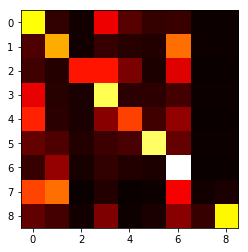

In [50]:
import matplotlib.pyplot as plt
plt.imshow(scores, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
0, 3 lf 
1, 6 gf
2, 4 neutral
7, 8 switch
inc 5


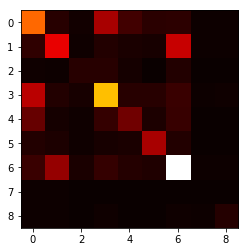

In [51]:
for i in range(9):
    scores[i]*=counts[i]
plt.imshow(scores, cmap='hot', interpolation='nearest')
plt.show()

In [52]:
model = xgb.XGBClassifier(eval_metric="mlogloss", max_depth=6)

training = merged[merged["split"]]
test = merged[merged["split"]==False]
X_train = np.array(training["all"].tolist())
y_train = np.array(training["Class"].tolist())

model.fit(X_train, y_train)

X_test=test["all"].tolist()
y_predxgb = model.predict_proba(X_test) 


NameError: name 'X_test' is not defined

In [53]:
X_test=test["all"].tolist()
y_predxgb = model.predict_proba(X_test) 


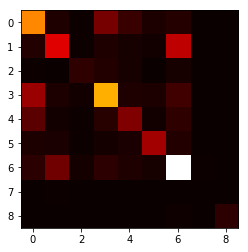

In [54]:
#row of scores will correspond to the true class
#columns will correspond to the predicted class
scores = np.zeros((9,9))
counts = np.zeros(9)
for row, values in enumerate(y_predxgb):
    trueclass = truth.iloc[row]-1
    scores[trueclass]+=values
    counts[trueclass]+=1
#print(scores)
#print(counts)

plt.imshow(scores, cmap='hot', interpolation='nearest')
plt.show()



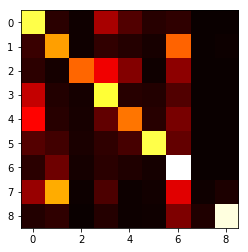

In [55]:
for i in range(9):
    scores[i]/=counts[i]
plt.imshow(scores, cmap='hot', interpolation='nearest')
plt.show()

In [57]:
mixedpred = ((y_pred)+(y_predxgb))/2

for preds in [y_pred, y_predxgb, mixedpred]:
    ls = []
    for row,values in enumerate(preds):
        trueclass = truth.iloc[row]-1
        prob = values[trueclass]
        ls.append(-np.log(prob+1e-6))

    print("Accuracy on test set:")
    print(np.mean(ls))

Accuracy on test set:
0.970707611738
Accuracy on test set:
0.915877740783
Accuracy on test set:
0.908283629449


In [61]:
merged["Text"]=merged["Text"].str.lower()

In [62]:
merged.head()

,ID,Gene,Text,Variation,Class,tokenized,wordbag,genebag,Sentences,tokenizedSentences,sentenceWordBag,bigrams,genesmentioned,geneofinterest,wordfeatures,mutType,sentenceWordFeatures,bigramfeatures,all,split
0,0,FAM58A,cyclin-dependent kinases (cdks) regulate a var...,Truncating Mutations,1,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...","{'Cyclin': 1, 'M': 1, 'orphan': 1, 'cyclin': 1...","[(Cyclin, M,), (M,, an), (an, orphan), (orphan...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",False
1,1,CBL,abstract background non-small cell lung canc...,W802*,2,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[(Using, select), (select, c-CBL), (c-CBL, som...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True
2,2,CBL,abstract background non-small cell lung canc...,Q249E,2,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...","{'Using': 1, 'select': 1, 'c-CBL': 1, 'somatic...","[(Using, select), (select, c-CBL), (c-CBL, som...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True
3,3,CBL,recent evidence has demonstrated that acquired...,N454D,3,"[Recent, evidence, has, demonstrated, that, ac...","{'Recent': 1, 'evidence': 1, 'demonstrated': 1...","{'JAK2': 1, 'CBL': 1, 'FLT3': 1, 'MPL': 1, 'NR...","15 Apart from N454D, all residues affected by ...","[15, Apart, from, N454D, ,, all, residues, aff...","{'15': 1, 'Apart': 1, 'N454D': 1, 'residues': ...","[(15, Apart), (Apart, from), (from, N454D,), (...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",True
4,4,CBL,oncogenic mutations in the monomeric casitas b...,L399V,4,"[Oncogenic, mutations, in, the, monomeric, Cas...","{'Oncogenic': 1, 'mutations': 1, 'monomeric': ...","{'CBL': 1, 'EGFR': 1, 'KIT': 1}","Finally, the third group constituted mutatio...","[Finally, ,, the, third, group, constituted, m...","{'Finally': 1, 'third': 1, 'group': 1, 'consti...","[(Finally,, the), (the, third), (third, group)...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0,

In [77]:
merged.head(1)

,ID,Gene,Text,Variation,Class,tokenized,wordbag,genebag,Sentences,tokenizedSentences,sentenceWordBag,bigrams,genesmentioned,geneofinterest,wordfeatures,mutType,sentenceWordFeatures,bigramfeatures,all
0,0,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,1,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...","{'Cyclin': 1, 'M': 1, 'orphan': 1, 'cyclin': 1...","[(Cyclin, M,), (M,, an), (an, orphan), (orphan...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [83]:
def stemList(list):
    stemmed = []
    for i in list:
        stemmed.append(sno.stem(i))
    return stemmed

def lowerList(list):
    lowered = []
    for i in list:
        lowered.append(i.lower())
    return lowered

In [81]:
sno = nltk.stem.SnowballStemmer('english')
merged["stemmed"]=merged["tokenized"].map(stemList)

In [84]:
merged["loweredtokens"]=merged["tokenized"].map(lowerList)

In [85]:
merged.head(2)

,ID,Gene,Text,Variation,Class,tokenized,wordbag,genebag,Sentences,tokenizedSentences,...,bigrams,genesmentioned,geneofinterest,wordfeatures,mutType,sentenceWordFeatures,bigramfeatures,all,stemmed,loweredtokens
0,0,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,1,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","Cyclin M, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...",...,"[(Cyclin, M,), (M,, an), (an, orphan), (orphan...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[cyclin-depend, kinas, (, cdks, ), regul, a, v...","[cyclin-dependent, kinases, (, cdks, ), regula..."
1,1,CBL,Abstract Background Non-small cell lung canc...,W802*,2,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...",Using select c-CBL somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...",...,"[(Using, select), (select, c-CBL), (c-CBL, som...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[abstract, background, non-smal, cell, lung, c...","[abstract, background, non-small, cell, lung, ..."


In [86]:
wordcounts = {}
for i in merged["loweredtokens"]:
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.9 and v>len(merged)*.1:
        abridgedsorted[k]=v
merged["tkfs"]=merged["loweredtokens"].map(lambda b: [int(word in b) for word in abridgedsorted.keys()])

wordcounts = {}
for i in merged["stemmed"]:
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsortedst = {}
for (k,v) in sortedwords:
    if v< len(merged)*.9 and v>len(merged)*.1:
        abridgedsortedst[k]=v
merged["stfs"]=merged["stemmed"].map(lambda b: [int(word in b) for word in abridgedsortedst.keys()])

In [90]:
logistictester(merged, "tkfs", "Class")
logistictester(merged, "stfs", "Class")

Accuracy on test set:
0.941154965812
Accuracy on training set:
0.473622472708
Accuracy on test set:
0.95800805684
Accuracy on training set:
0.53279318227


In [91]:
len(merged["stfs"][0])

2623

In [92]:
len(merged["tkfs"][0])

3580

In [93]:
abridgedsortedst.keys()

dict_keys(['20', 'like', 'control', 'follow', 'tabl', 'same', 'dna', 'respect', 'line', 'region', 'when', 'acid', 'involv', 'could', 'affect', 'known', 'possibl', 'some', 'figur', 'type', 'thus', 'method', 'perform', '7', 'within', 'tumor', 'presenc', 'case', 'chang', 'repres', 'those', 'normal', 'becaus', 'direct', 'bind', '12', 'target', 'wild-typ', 'b', 'confirm', 'select', '15', 'remain', 'first', 'patient', 'requir', 'analyz', 'role', 'they', 'did', '8', 'amino', 'common', 'generat', 'potenti', 'base', 'whether', 'occur', 'sampl', '9', 'alter', 'obtain', 'predict', 'signal', 'factor', 'accord', 'c', 'wherea', 'independ', 'clinic', 'residu', '50', 'contrast', 'through', 'find', 'respons', 'major', 'total', 'structur', 'group', 'genet', 'experi', 'then', 'there', '14', 'time', 'reveal', 'higher', 'assess', 'molecular', 'under', 'interest', '11', '30', 'therefor', 'multipl', 'model', 'ani', 'locat', '16', 'examin', 'vitro', 'support', '13', 'investig', 'larg', 'caus', 'small', 'lead'

In [94]:
abridgedsorted.keys()

dict_keys(['20', 'human', 'mutant', 'same', 'dna', 'number', 'when', 'could', 'table', 'several', 'known', 'proteins', 'some', 'thus', '7', 'associated', 'within', 'presence', 'figure', 'effect', 'those', 'additional', 'because', '12', 'performed', 'wild-type', 'functional', 'function', 'b', 'control', '15', 'likely', 'sequence', 'first', 'important', 'present', 'respectively', 'methods', 'expressed', 'they', 'did', '8', 'amino', 'showed', 'levels', 'whether', 'binding', '9', 'high', 'activation', 'role', 'c', 'whereas', 'result', 'specific', 'increased', '50', 'tumor', 'indicated', 'patients', 'suggest', 'significant', 'through', 'assay', 'analyzed', 'contrast', 'genes', 'sequencing', 'effects', 'acid', 'then', 'there', 'containing', 'region', 'total', 'previous', 'detected', '14', 'determined', 'obtained', 'higher', '11', 'molecular', 'clinical', '30', 'therefore', 'site', 'any', '16', 'multiple', 'vitro', 'show', '13', 'highly', 'type', 'recently', 'small', 'suggesting', 'would', 'r

In [109]:
merged["tokenizedSentenceslower"]=merged["tokenizedSentences"].map(lowerList)

In [110]:
merged["stemmedSentences"]=merged["tokenizedSentenceslower"].map(stemList)

In [111]:
wordcounts = {}
for i in merged["tokenizedSentenceslower"]:
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsorted = {}
for (k,v) in sortedwords:
    if v< len(merged)*.9 and v>len(merged)*.1:
        abridgedsorted[k]=v
merged["tksfs"]=merged["tokenizedSentenceslower"].map(lambda b: [int(word in b) for word in abridgedsorted.keys()])

wordcounts = {}
for i in merged["stemmedSentences"]:
    words = set(i)
    for word in words:
        wordcounts[word] = wordcounts.get(word,0)+1
sortedwords = sorted(wordcounts.items(), key=lambda c: c[1], reverse=True)
abridgedsortedst = {}
for (k,v) in sortedwords:
    if v< len(merged)*.9 and v>len(merged)*.1:
        abridgedsortedst[k]=v
merged["stsfs"]=merged["stemmedSentences"].map(lambda b: [int(word in b) for word in abridgedsortedst.keys()])

In [112]:
logistictester(merged, "tksfs", "Class")
logistictester(merged, "stsfs", "Class")
logistictester(merged, "sentenceWordFeatures", "Class")

Accuracy on test set:
1.36261181474
Accuracy on training set:
1.16974478285
Accuracy on test set:
1.3672453906
Accuracy on training set:
1.17405370866
Accuracy on test set:
1.39396178973
Accuracy on training set:
1.22210601382


In [113]:
print(len(merged["tksfs"][0]))
print(len(merged["stsfs"][0]))
print(len(merged["sentenceWordFeatures"][0]))

594
562
606


In [114]:
merged["tkall"]= merged["tkfs"]+merged["tksfs"]
merged["stall"]= merged["stfs"]+merged["stsfs"]

logistictester(merged, "tkall", "Class")
logistictester(merged, "stall", "Class")

Accuracy on test set:
0.898992950261
Accuracy on training set:
0.410107793969
Accuracy on test set:
0.915415076969
Accuracy on training set:
0.458825115764


In [115]:
merged.columns

Index(['ID', 'Gene', 'Text', 'Variation', 'Class', 'tokenized', 'wordbag',
       'genebag', 'Sentences', 'tokenizedSentences', 'sentenceWordBag',
       'bigrams', 'genesmentioned', 'geneofinterest', 'wordfeatures',
       'mutType', 'sentenceWordFeatures', 'bigramfeatures', 'all', 'stemmed',
       'loweredtokens', 'tkfs', 'stfs', 'split', 'tokenizedSentenceslower',
       'stemmedSentences', 'tksfs', 'stsfs', 'tkall', 'stall'],
      dtype='object')

In [116]:
merged["x"]=merged["wordfeatures"]+merged["sentenceWordFeatures"]
logistictester(merged, "x", "Class")

Accuracy on test set:
0.90323515643
Accuracy on training set:
0.416149729852


In [118]:
merged["all"]=merged["tkfs"]+merged["genesmentioned"]+merged["geneofinterest"]+merged["mutType"]+merged["tksfs"]+merged["bigramfeatures"]
merged["allst"]=merged["stfs"]+merged["genesmentioned"]+merged["geneofinterest"]+merged["mutType"]+merged["stsfs"]+merged["bigramfeatures"]
logistictester(merged, "all", "Class")
logistictester(merged, "allst", "Class")


Accuracy on test set:
0.881107744171
Accuracy on training set:
0.358872645365
Accuracy on test set:
0.891478146387
Accuracy on training set:
0.394260924059


In [119]:
print(len(merged["all"][0]))
print(len(merged["allst"][0]))


9291
8302


In [132]:
print(len(merged["bigramfeaturesfiltered"][0]))
print(len(merged["bigramfeatures"][0]))

logistictester(merged, "bigramfeaturesfiltered", "Class")
logistictester(merged, "bigramfeatures", "Class")

1128
4572
Accuracy on test set:
1.5570535051
Accuracy on training set:
1.4535594051
Accuracy on test set:
1.37573625335
Accuracy on training set:
1.1235283018


In [133]:
merged["allft"]=merged["tkfs"]+merged["genesmentioned"]+merged["geneofinterest"]+merged["mutType"]+merged["tksfs"]+merged["bigramfeaturesfiltered"]
merged["all"]=merged["tkfs"]+merged["genesmentioned"]+merged["geneofinterest"]+merged["mutType"]+merged["tksfs"]+merged["bigramfeatures"]

logistictester(merged, "allft", "Class")
logistictester(merged, "all", "Class")

Accuracy on test set:
0.887567715586
Accuracy on training set:
0.393044800739
Accuracy on test set:
0.881107744171
Accuracy on training set:
0.358872645365


In [135]:
print(len(merged["all"][0]))
print(len(merged["allft"][0]))

9291
5847


In [137]:
logistictester(merged, "allft", "Class", C=5e-2)
logistictester(merged, "allft", "Class", C=1e-2)
logistictester(merged, "allft", "Class", C=5e-3)
logistictester(merged, "all", "Class", C=5e-1)
logistictester(merged, "all", "Class", C=1e-2)
logistictester(merged, "all", "Class", C=5e-3)

Accuracy on test set:
0.92086615935
Accuracy on training set:
0.199745516484
Accuracy on test set:
0.887567715586
Accuracy on training set:
0.393044800739
Accuracy on test set:
0.925553440886
Accuracy on training set:
0.532481473998
Accuracy on test set:
1.27982564631
Accuracy on training set:
0.083359046324
Accuracy on test set:
0.881107744171
Accuracy on training set:
0.358872645365
Accuracy on test set:
0.911233803094
Accuracy on training set:
0.484541892687


In [155]:
logistictester(merged, "tksfs", "Class")   #sentences lowered from genes or allele
logistictester(merged, "sentencegWordFeatures", "Class")   # sentencegWordFeatures only from genes
logistictester(merged, "sentencevWordFeatures", "Class")   

Accuracy on test set:
1.36261181474
Accuracy on training set:
1.16974478285
Accuracy on test set:
1.06788325526
Accuracy on training set:
0.755133174496
Accuracy on test set:
1.61814665159
Accuracy on training set:
1.51613091716


In [159]:
print(len(merged["tksfs"][0]))
print(len(merged["sentencegWordFeatures"][0]))
print(len(merged["sentencevWordFeatures"][0]))

594
1696
293


In [157]:
merged["allsentences"] = merged["sentencegWordFeatures"] + merged["sentencevWordFeatures"]
print(len(merged["allsentences"][0]))
logistictester(merged, "allsentences", "Class")  

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


1989
Accuracy on test set:
1.03711558563
Accuracy on training set:
0.698230079295


In [158]:
merged.head(2)

,ID,Gene,Text,Variation,Class,tokenized,wordbag,genebag,Sentences,tokenizedSentences,...,allft,gSentences,vSentences,tokenizedvSentences,sentencevWordBag,sentencevWordFeatures,tokenizedgSentences,sentencegWordBag,sentencegWordFeatures,allsentences
0,0,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,1,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","{'Cyclin-dependent': 1, 'kinases': 1, 'CDKs': ...","{'FAM58A': 1, 'CDK8': 1, 'CCND1': 1, 'MYCN': 1}","cyclin m, an orphan cyclin, is the product of...","[Cyclin, M, ,, an, orphan, cyclin, ,, is, the,...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","cyclin m, an orphan cyclin, is the product of...",,[],{},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[cyclin, m, ,, an, orphan, cyclin, ,, is, the,...","{'cyclin': 1, 'orphan': 1, 'product': 1, 'fam5...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, ..."
1,1,CBL,Abstract Background Non-small cell lung canc...,W802*,2,"[Abstract, Background, Non-small, cell, lung, ...","{'Abstract': 1, 'Background': 1, 'Non-small': ...","{'EGFR': 1, 'MET': 1, 'KRAS': 1, 'CBL': 1, 'SR...",using select c-cbl somatic mutations such as ...,"[Using, select, c-CBL, somatic, mutations, suc...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",c-cbl is an e3 ubiquitin ligase and adaptor m...,using select c-cbl somatic mutations such as ...,"[using, select, c-cbl, somatic, mutations, suc...","{'using': 1, 'select': 1, 'c-cbl': 1, 'somatic...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[c-cbl, is, an, e3, ubiquitin, ligase, and, ad...","{'c-cbl': 1, 'e3': 1, 'ubiquitin': 1, 'ligase'...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, ..."


In [160]:
del merged["wordbag"]
del merged["genebag"]

In [161]:
merged.columns

Index(['ID', 'Gene', 'Text', 'Variation', 'Class', 'tokenized', 'Sentences',
       'tokenizedSentences', 'sentenceWordBag', 'bigrams', 'genesmentioned',
       'geneofinterest', 'wordfeatures', 'mutType', 'sentenceWordFeatures',
       'bigramfeatures', 'all', 'stemmed', 'loweredtokens', 'tkfs', 'stfs',
       'split', 'tokenizedSentenceslower', 'stemmedSentences', 'tksfs',
       'stsfs', 'tkall', 'stall', 'x', 'allst', 'bigramsfiltered',
       'bigramfeaturesfiltered', 'allft', 'gSentences', 'vSentences',
       'tokenizedvSentences', 'sentencevWordBag', 'sentencevWordFeatures',
       'tokenizedgSentences', 'sentencegWordBag', 'sentencegWordFeatures',
       'allsentences'],
      dtype='object')

In [162]:
del merged["genesmentioned"]
del merged["geneofinterest"]
del merged["x"]
del merged["stemmed"]
del merged["stfs"]
del merged["stemmedSentences"]
del merged["stsfs"]
del merged["stall"]
del merged["allst"]

In [167]:
merged.columns

Index(['ID', 'Gene', 'Text', 'Variation', 'Class', 'tokenized', 'Sentences',
       'tokenizedSentences', 'sentenceWordBag', 'bigrams', 'wordfeatures',
       'mutType', 'sentenceWordFeatures', 'bigramfeatures', 'all',
       'loweredtokens', 'tkfs', 'split', 'tokenizedSentenceslower', 'tksfs',
       'tkall', 'bigramsfiltered', 'bigramfeaturesfiltered', 'allft',
       'gSentences', 'vSentences', 'tokenizedvSentences', 'sentencevWordBag',
       'sentencevWordFeatures', 'tokenizedgSentences', 'sentencegWordBag',
       'sentencegWordFeatures', 'allsentences'],
      dtype='object')

In [ ]:
df["all"]=df["wordfeatures"]+df["genesmentioned"]+df["geneofinterest"]+df["mutType"]+df["sentenceWordFeatures"]+df["bigramfeatures"]
nEmpty

In [165]:
nEmpty

3426

In [166]:
len(merged)

3689

In [174]:
for row,sentence in enumerate(merged["gSentences"]):
    if len(sentence)==0:
        if len(merged["vSentences"][row])>0:
            print(row)
            print(merged["Gene"][row])
            

39
DICER1
40
DICER1
78
CCND3
95
TGFBR1
98
TGFBR2
99
TGFBR2
284
NKX2-1
367
EPAS1
373
TP53
374
TP53
375
TP53
377
TP53
379
TP53
383
TP53
394
TP53
408
TP53
411
TP53
413
TP53
421
TP53
424
TP53
425
TP53
426
TP53
429
TP53
432
TP53
436
TP53
442
TP53
443
TP53
445
TP53
451
TP53
462
TP53
465
TP53
485
TP53
488
TP53
491
TP53
505
TP53
509
TP53
511
TP53
512
TP53
513
TP53
522
TP53
526
TP53
527
TP53
531
TP53
617
FBXW7
626
FBXW7
627
FBXW7
647
CDKN2A
656
CDKN2A
658
CDKN2A
672
CDKN2A
674
CDKN2A
676
CDKN2A
681
CDKN2A
682
CDKN2A
707
ERBB2
716
ERBB2
770
ERBB2
791
ERBB4
795
ERBB4
796
ERBB4
823
BRIP1
824
BRIP1
825
BRIP1
828
BRIP1
838
ABL1
839
ABL1
840
ABL1
843
ABL1
844
ABL1
845
ABL1
846
ABL1
847
ABL1
848
ABL1
849
ABL1
850
ABL1
851
ABL1
852
ABL1
853
ABL1
855
ABL1
856
ABL1
857
ABL1
859
ABL1
860
ABL1
861
ABL1
862
ABL1
964
ESR1
967
ESR1
971
ESR1
1154
KMT2C
1157
KMT2C
1225
PIK3CB
1227
PIK3CB
1245
PIK3R1
1246
PIK3R1
1258
PIK3R1
1259
PIK3R1
1260
PIK3R1
1267
PIK3R1
1268
PIK3R1
1296
HRAS
1343
AKT1
1576
RAD54L
1964
CTNN

In [ ]:
for row,sentence in enumerate(merged["gSentences"]):
    if len(sentence)==0:
        if len(merged["vSentences"][row])>0:
            print(row)
            print(merged["Gene"][row])
            